# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import imageio
import numpy as np
import itertools
import json

import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.xception import Xception
from keras.layers import Dense, Input, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras.utils import multi_gpu_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# dataset duplicate sanity check
base_dir = "/content/drive/My Drive/Deep Learning Project/"
test_dir = os.path.join(base_dir, "test")
train_dir = os.path.join(base_dir, "train")
overlaps = {}
for class_name in os.listdir(test_dir):
    train_imgs = os.listdir(os.path.join(train_dir, class_name))
    test_imgs = os.listdir(os.path.join(test_dir, class_name))
    print(class_name, len(train_imgs), len(test_imgs))
    overlaps[class_name] = []
    for i in test_imgs:
        if i in train_imgs:
            overlaps[class_name].append(i)
print("\noverlaps:")
for i in overlaps:
    print(i, len(overlaps[i]))

COVID-19 176 43
NORMAL 176 43
Viral Pneumonia 176 43

overlaps:
COVID-19 0
NORMAL 0
Viral Pneumonia 0


# Configure Input and Output Paths

In [ ]:
base_dir = "/content/drive/My Drive/Deep Learning Project/"
train_path = os.path.join(base_dir, "train")
test_path = os.path.join(base_dir, "test")

In [ ]:
def create_session_paths(session_name, overwrite=False, base_dir="/content/drive/My Drive/Deep Learning Project/"):
    models_dir = os.path.join(base_dir, "models")
    session_dir = os.path.join(models_dir, session_name)
    # Prevent accidental overwriting of previous sessions
    try:
        os.mkdir(session_dir)
    except FileExistsError:
        if not overwrite:
            print("Set overwrite to True if you wish to continue")
            raise FileExistsError
        print("overwriting session")

    model = os.path.join(session_dir, "model.h5")
    history = os.path.join(session_dir, "history.json")
    training_log = os.path.join(session_dir, "logs.csv")
    training_config = os.path.join(session_dir, "config.json")
    classification_report = os.path.join(session_dir, "classification_report.txt")
    return {"model": model,
            "history": history,
            "logs": training_log,
            "config": training_config,
            "classification_report": classification_report}


In [ ]:
session_name = "xception"
session_paths = create_session_paths(session_name, overwrite=True)

overwriting session


# Configure Training Regimen

In [ ]:
# Dataset config
input_shape = (256, 256, 3)
# input_shape = (512, 512, 3)
num_classes = 3
input_tensor = Input(shape=input_shape)

# Generator configuration
# pixel rescale may change if different color space is used
pixel_rescale = 1./255
validation_split = 0.3

target_size = (input_shape[0], input_shape[1])
# arbitrary value chosen. Not sure what a good batch size is for training.
batch_size = 40
max_epochs = 60

#optimizer
initial_lr = 5e-4
min_lr = 1e-7
lr_reduction_patience = 4
lr_change_factor = 0.2
early_stop_patience = 30
opt = Adam(learning_rate=initial_lr)

#callbacks
monitor_metric = 'val_accuracy'

config = {"input_shape": input_shape,
          "num_classes": num_classes,
          "pixel_rescale": pixel_rescale,
          "validation_split": validation_split,
          "batch_size": batch_size,
          "epochs": max_epochs,
          "optimizer": str(type(opt)),
          "initial_lr": initial_lr,
          "final_lr": min_lr,
          "lr_factor": lr_change_factor,
          "callback_monitor": monitor_metric}

print(early_stop_patience)
with open(session_paths["config"], 'w') as f:
    json.dump(config, f)

30


# Load Training Set and Validation Set (Keras ImageDataGenerator)

In [ ]:
data_generator = ImageDataGenerator(
    rescale=pixel_rescale,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=validation_split
)

train_gen = data_generator.flow_from_directory(
    train_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)
val_gen = data_generator.flow_from_directory(
    train_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_gen = ImageDataGenerator(
    rescale=pixel_rescale
    ).flow_from_directory(
        test_path,
        target_size=target_size,
        color_mode="rgb",
        shuffle=False,
        class_mode="categorical",
        batch_size=1
    )

Found 372 images belonging to 3 classes.
Found 156 images belonging to 3 classes.
Found 129 images belonging to 3 classes.


# Model Creation

In [ ]:
xception = Xception(
    input_tensor=input_tensor,
    include_top=False,
    weights='imagenet'
)

x = xception.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=xception.input, outputs=predictions)

for i, layer in enumerate(xception.layers):
    print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_act

## Training

In [ ]:
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint(session_paths["model"],
                             monitor=monitor_metric,
                             verbose=1,
                             save_best_only=True,
                             mode='max')

reduce_lr = ReduceLROnPlateau(monitor=monitor_metric,
                              factor=lr_change_factor,
                              patience=lr_reduction_patience,
                              verbose=1,
                              mode='max',
                              min_lr=min_lr)

csv_logger = CSVLogger(session_paths["logs"])

early_stopper = EarlyStopping(monitor=monitor_metric,
                              patience=early_stop_patience,
                              verbose=1,
                              mode='max')

callbacks_list = [checkpoint, reduce_lr, csv_logger, early_stopper]

try:
    model = multi_gpu_model(model)
except:
    print("single GPU in use")

history = model.fit_generator(train_gen, validation_data=val_gen, epochs=max_epochs, verbose=1, callbacks=callbacks_list)

with open(session_paths["history"], 'w') as f:
    pd.DataFrame(history.history).to_json(f)

Instructions for updating:
Use `tf.distribute.MirroredStrategy` instead.
single GPU in use
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/60
10/10 [==============================] - ETA: 0s - loss: 0.7665 - accuracy: 0.6909
Epoch 00001: val_accuracy improved from -inf to 0.60256, saving model to /content/drive/My Drive/Deep Learning Project/models/xception/model.h5
10/10 [==============================] - 23s 2s/step - loss: 0.7665 - accuracy: 0.6909 - val_loss: 1.9609 - val_accuracy: 0.6026
Epoch 2/60
10/10 [==============================] - ETA: 0s - loss: 0.2076 - accuracy: 0.9274
Epoch 00002: val_accuracy improved from 0.60256 to 0.82692, saving model to /content/drive/My Drive/Deep Learning Project/models/xception/model.h5
10/10 [==============================] - 21s 2s/step - loss: 0.2076 - accuracy: 0.9274 - val_loss: 0.7127 - val_accuracy: 0.8269
Epoch 3/60
10/10 [==============================] - ETA: 0s - loss: 0.1997 - accuracy: 0.9462
Ep

In [ ]:
model = keras.models.load_model(session_paths["model"])
predictions = model.predict_generator(test_gen, verbose=1)

129/129 [==============================] - 3s 27ms/step


In [ ]:
print(predictions.shape)

(129, 3)


In [ ]:
predict = np.argmax(predictions, axis=1)

In [ ]:
cols = train_gen.class_indices.keys()
df_preds = pd.DataFrame(predictions, columns=cols)

df_preds.head()

,COVID-19,NORMAL,Viral Pneumonia
0,1.000000,1.103808e-07,1.178908e-07
1,0.999999,4.115176e-07,5.589087e-07
2,1.000000,7.628065e-10,6.897415e-11
3,1.000000,5.330992e-13,1.558938e-14
4,1.000000,7.328277e-09,2.282189e-10


In [ ]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    # set the size of the figure here
    plt.figure(figsize=(15,10))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=80) # set x-axis text angle here
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[43  0  0]
 [ 0 41  2]
 [ 0  4 39]]


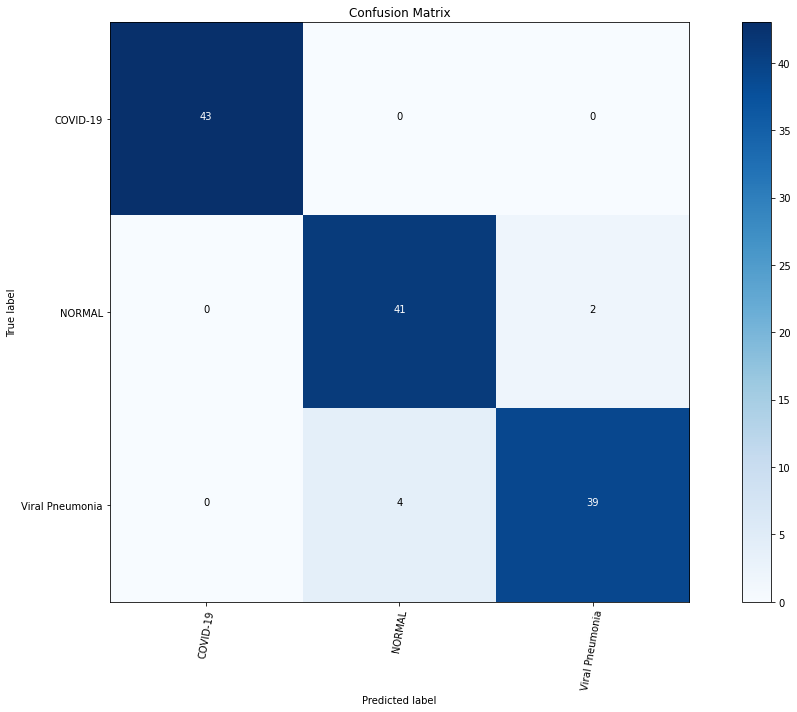

In [ ]:
cm = confusion_matrix(test_gen.classes, predictions.argmax(axis=1))

cm_plot_labels = cols
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [ ]:
y_pred_binary = predictions.argmax(axis=1)

report =  classification_report(test_gen.classes, y_pred_binary, target_names=cm_plot_labels)

print(report)

with open(session_paths["classification_report"], 'w') as f:
    f.write(report)

                 precision    recall  f1-score   support

       COVID-19       1.00      1.00      1.00        43
         NORMAL       0.91      0.95      0.93        43
Viral Pneumonia       0.95      0.91      0.93        43

       accuracy                           0.95       129
      macro avg       0.95      0.95      0.95       129
   weighted avg       0.95      0.95      0.95       129



<Figure size 432x288 with 0 Axes>

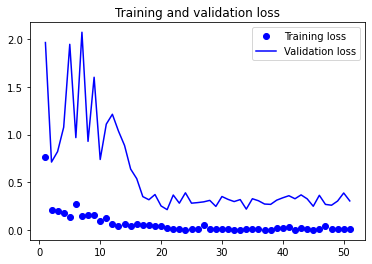

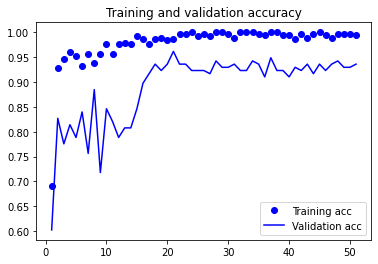

<Figure size 432x288 with 0 Axes>

In [ ]:
# display the loss and accuracy curves

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()